Use <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html"> Welch's T-test</a> to identify the i-bang magnitude (`iMag`) cut such that the redshift distributions PDF1 and PDF2 have identical average values.              


* PDF1 : quasars with iMag <= 75% percentile of iMag
* PDF2 : quasars with 50% < iMag <= ?

We find the upper boundary (?), by using different treshholds of p-value.

In [1]:
%matplotlib inline
import sys
sys.path.append('/home/mehdi/github/LSSutils')
import matplotlib.pyplot as plt
import fitsio as ft
import numpy as np
import LSSutils.utils as ut
import pandas as pd
from scipy.stats import ttest_ind

camb is not installed!


In [2]:
plt.rc('font', size=12)

In [3]:
SYSMAPS = pd.read_hdf('/home/mehdi/data/eboss/sysmaps/SDSS_HI_imageprop_nside256.h5')

def read_cat(CAP, 
             band='i', 
             field='MODELMAG', 
             index_b=dict(zip(['u', 'g', 'r', 'i', 'z'], np.arange(5))),
             index_e = dict(zip(['u', 'g', 'r', 'i', 'z'], [4.239,3.303,2.285,1.698,1.263])),
             nside   = 256,
             sysmaps = SYSMAPS,
            ):
    # read data
    print(index_b[band], field, nside, band, CAP)
    cfull = ft.read('/home/mehdi/data/eboss/v6/eBOSS_QSO_full_'+CAP+'_v6.dat.fits')
    cat   = ft.read('/home/mehdi/data/eboss/v6/eBOSS_QSO_clustering_'+CAP+'_v6.dat.fits')
    inc   = np.in1d(cfull['QSO_ID'], cat['QSO_ID'])
    mycat = cfull[inc]
    
    assert np.array_equal(mycat['QSO_ID'], cat['QSO_ID'])
    hpix   = ut.radec2hpix(nside, cat['RA'], cat['DEC'])
    imag  = mycat[field][:, index_b[band]].astype('float64')
    imagc = imag - index_e[band]*sysmaps['ebv'][hpix]
    
    galaxy = pd.DataFrame(dict(imagc=imagc,
                               ra=cat['RA'].astype('float64'),
                               dec=cat['DEC'].astype('float64'),
                               z=cat['Z'].astype('float64'),
                               w=cat['WEIGHT_CP']*cat['WEIGHT_NOZ']*cat['WEIGHT_SYSTOT'], #
                               hpix=hpix))
    # 
    stats = galaxy.describe()
    print(stats['imagc'])
    galaxy['0'] =  galaxy['imagc'] <= stats['imagc']['25%']
    galaxy['1'] = (stats['imagc']['25%'] < galaxy['imagc']) & (galaxy['imagc'] <= stats['imagc']['50%'])
    galaxy['2'] = (stats['imagc']['50%'] < galaxy['imagc']) & (galaxy['imagc'] <= stats['imagc']['75%'])
    galaxy['3'] = (galaxy['imagc'] > stats['imagc']['75%'])
    
    # add psf_g
    galaxy['psf_g'] = sysmaps['psf_g'][galaxy['hpix']].values
    return galaxy


def read_random(CAP, nside=256, sysmaps=SYSMAPS):
    # read data
    cat    = ft.read('/home/mehdi/data/eboss/v6/eBOSS_QSO_clustering_'+CAP+'_v6.ran.fits')
    galaxy = pd.DataFrame(dict(
                               ra=cat['RA'].astype('float64'),
                               dec=cat['DEC'].astype('float64'),
                               w=cat['WEIGHT_SYSTOT']*cat['WEIGHT_CP']*cat['WEIGHT_NOZ'],
                               hpix=ut.radec2hpix(nside, cat['RA'], cat['DEC'])))
    galaxy['psf_g'] = sysmaps['psf_g'][galaxy['hpix']].values
    return galaxy   



def make(CAP):
    '''
        make plots
        
    '''
    mycat = read_cat(CAP)
    myran = read_random(CAP)
    
    imag_stats = mycat.describe()['imagc']
    

    # define bins, labels, etc
    psf_bins = [0.9, 1.341252, 1.451386, 1.564080, 2.303862]
    labels   = {'0':'i<=%.2f'%imag_stats['25%'],
                '1':'%.2f<i<=%.2f'%(imag_stats['25%'], imag_stats['50%']),
                '2':'%.2f<i<=%.2f'%(imag_stats['50%'], imag_stats['75%']),
                '3':'%.2f<i'%imag_stats['75%']}    

    # plots
    fig, ax = plt.subplots(ncols=3, figsize=(20, 4))
    fig.suptitle(CAP)
    # hist of i-band mag (ext corrected)
    ax[0].hist(mycat['imagc'], histtype='step', color='k')
    for percentile in ['25%', '50%', '75%']:
        ax[0].axvline(imag_stats[percentile], linestyle='-', color='k')
    ax[0].set_xlabel('MODELMAG_i - EBV')
    ax[0].set_ylabel('Nqso')
    
    
    # hist of redshift
    c  = ['grey', 'grey', 'grey', 'r']
    ls = ['-', '--', ':', '-.']
    for i in range(4):
        mask=str(i)
        n,_,_ = ax[1].hist(mycat.loc[mycat[mask],'z'], 
                           range=(0.79, 2.21),
                           histtype='step', bins=50, 
                           weights=mycat.loc[mycat[mask], 'w'], 
                           color=c[i],
                           linestyle=ls[i], 
                          label=labels[mask])
        #ax[1].text(0.4, 0.3-i*0.07, 
        #           labels[mask], color=c[i],
        #           transform=ax[1].transAxes)    
    ax[1].legend(loc='lower center')
    ax[1].set_xlabel('z')
    ax[1].set_ylabel('Nqso')
    
    # histogram of psf_g
    c = ['k', 'b', 'r', 'g']
    for i in range(4):
        stri    = str(i)
        mycat_i = mycat.loc[mycat[stri],:]
        ratio   = mycat_i.w.sum()/myran.w.sum()
        nnbar   = []
        error   = []
        for j in range(0, len(psf_bins)-1):
            wcat = mycat_i.w[(mycat_i['psf_g']>=psf_bins[j]) & (mycat_i['psf_g']<psf_bins[j+1])]
            wran = myran.w[(myran['psf_g']>=psf_bins[j]) & (myran['psf_g']<psf_bins[j+1])]
            mean = wcat.sum()/(wran.sum()*ratio)
            err  = np.sqrt(wcat.sum())/ (wran.sum()*ratio)
            nnbar += [mean]
            error += [err]
        ax[2].errorbar(psf_bins[:-1], nnbar, yerr=error, marker='o', color=c[i])
        ax[2].text(0.4, 0.3-i*0.07, 
                   labels[stri], color=c[i],
                   transform=ax[2].transAxes) 
    ax[2].set_xlabel('PSF_G')
    ax[2].set_ylabel('N/Nbar')

3 MODELMAG 256 i NGC
count    216893.000000
mean         20.473679
std           0.835807
min          17.615686
25%          19.948435
50%          20.585423
75%          21.108092
max          22.773839
Name: imagc, dtype: float64
3 MODELMAG 256 i SGC
count    125501.000000
mean         20.422804
std           0.840207
min          17.712046
25%          19.888728
50%          20.525544
75%          21.054576
max          29.095818
Name: imagc, dtype: float64


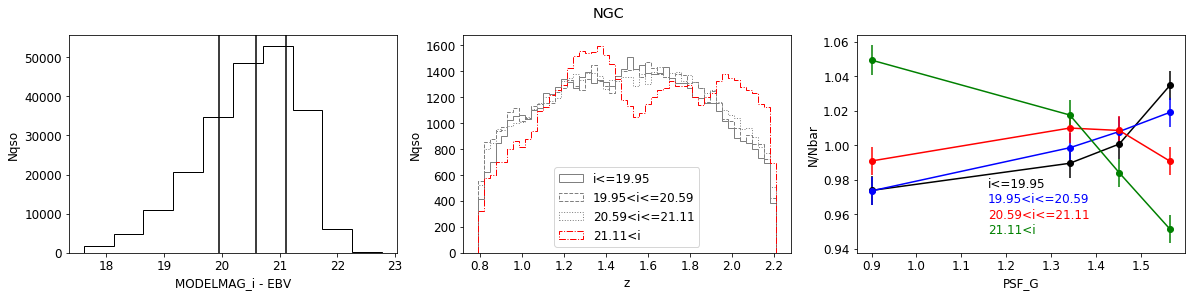

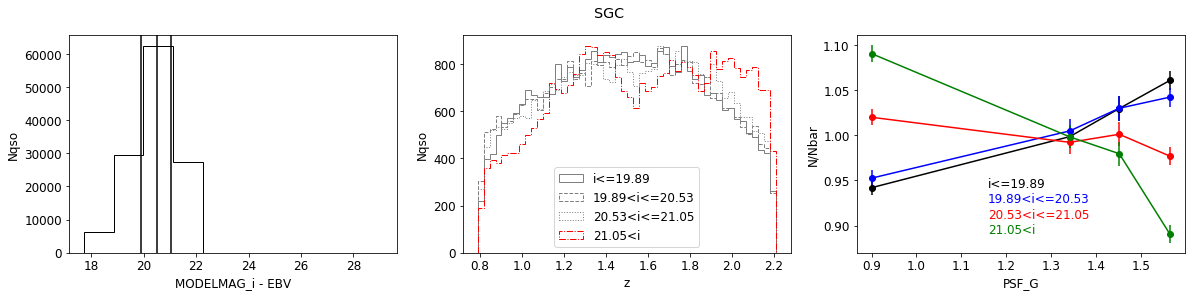

In [4]:
make('NGC')
make('SGC')

In [5]:
def find_icut(CAP, pvalue_crit=0.0001, ax=None):
    mycat  = read_cat(CAP)
    imag_stats  = mycat.describe()['imagc']
    good_sample = mycat[mycat['imagc'] <= imag_stats['75%']]['z']

    uc_best = None
    for i,uc in enumerate(np.arange(0.99*imag_stats['75%'], 1.001*imag_stats['max'], 0.001)):
        mask_bad    = (mycat['imagc']<=uc) & (mycat['imagc']>imag_stats['50%'])
        bad_sample  = mycat[mask_bad]['z']
        pvalue      = ttest_ind(good_sample, bad_sample, equal_var=True)[1] 
        if i%20==0:print('%.6f %.6f'%(uc, pvalue))
        if pvalue < pvalue_crit:
            uc_best=uc
            print('best cut %.6f with p-value %.6f'%(uc_best, pvalue))
            break   
            
            
    # add this as sample 5
    labels   = {0:'i<=%.2f [75%%]'%imag_stats['75%'],
                1:'%.2f[50%%]<i<=%.2f[best]'%(imag_stats['50%'], uc_best),
                2:'%.2f[50%%]<i<=%.2f[75%%]'%(imag_stats['50%'], imag_stats['75%'])}
    
    # hist of redshift
    c  = ['grey', 'r', 'b']
    ls = ['-', '--', ':']
    if ax is None:ax = plt.subplot()
    ax.set_title(CAP+' pvalue : %.1e'%pvalue_crit)
    for i, mask in enumerate([(mycat['imagc']<=imag_stats['75%']),
                              (mycat['imagc']<=uc_best) & (mycat['imagc']>imag_stats['50%']),
                              (mycat['imagc']<=imag_stats['75%']) & (mycat['imagc']>imag_stats['50%'])]):
        n,_,_ = ax.hist(mycat[mask]['z'], 
                        range=(0.79, 2.21),
                        histtype='step', bins=50, 
                        weights=mycat[mask]['w'], 
                        color=c[i],
                        linestyle=ls[i], 
                        label=labels[i], 
                        density=True)
        #ax[1].text(0.4, 0.3-i*0.07, 
        #           labels[mask], color=c[i],
        #           transform=ax[1].transAxes)    
    ax.legend(loc='lower center')
    ax.set_xlabel('z')
    ax.set_ylabel('Nqso (normed)')

3 MODELMAG 256 i NGC
count    216893.000000
mean         20.473679
std           0.835807
min          17.615686
25%          19.948435
50%          20.585423
75%          21.108092
max          22.773839
Name: imagc, dtype: float64
20.897011 0.337212
20.917011 0.269105
20.937011 0.289547
20.957011 0.367652
20.977011 0.174022
20.997011 0.101833
21.017011 0.065961
21.037011 0.052789
21.057011 0.050512
21.077011 0.021189
best cut 21.084011 with p-value 0.009566
3 MODELMAG 256 i NGC
count    216893.000000
mean         20.473679
std           0.835807
min          17.615686
25%          19.948435
50%          20.585423
75%          21.108092
max          22.773839
Name: imagc, dtype: float64
20.897011 0.337212
20.917011 0.269105
20.937011 0.289547
20.957011 0.367652
20.977011 0.174022
20.997011 0.101833
21.017011 0.065961
21.037011 0.052789
21.057011 0.050512
21.077011 0.021189
21.097011 0.006783
21.117011 0.002598
21.137011 0.000748
21.157011 0.000266
21.177011 0.000193
21.197011 0.000033

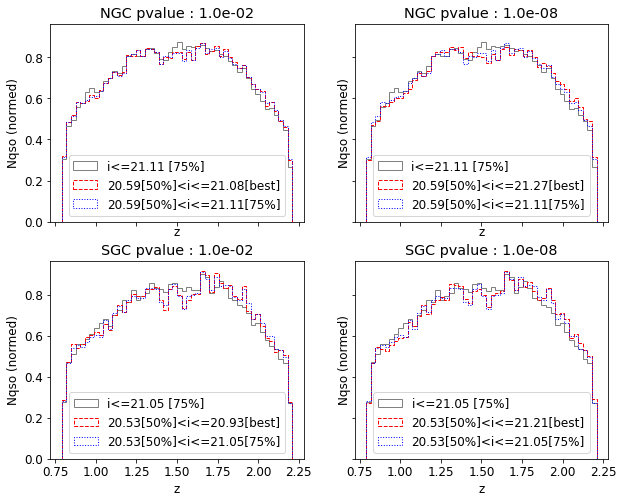

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8), sharex=True, sharey=True)
ax = ax.flatten()
find_icut('NGC', pvalue_crit=0.01,  ax=ax[0])
find_icut('NGC', pvalue_crit=0.00000001,  ax=ax[1])
find_icut('SGC', pvalue_crit=0.01, ax=ax[2])
find_icut('SGC', pvalue_crit=0.00000001, ax=ax[3])